# Reading and training tom and jerry dataset from kaggle

## Imports and definations

### Imports

In [1]:
import torch
from torch import nn

from torch.utils.data import DataLoader, random_split

import torchvision

from pathlib import Path

from matplotlib import pyplot as plt

import lightning as L

## Run

In [2]:
fabric = L.Fabric()
fabric.launch()

### get data

#### In pc

In [3]:
data_path = Path(
    '/home/ramin/ramin_programs/files/datasets/tom-and-jerry-image-classification/tom_and_jerry/tom_and_jerry')

#### In colab

In [3]:
from google.colab import userdata

In [4]:
kaggle_target_path = Path('/root/.kaggle/kaggle.json')

kaggle_target_path.parent.mkdir(exist_ok=True, parents=True)

with open(kaggle_target_path,'w') as f:
  f.write(userdata.get('Kaggle'))

In [5]:
! kaggle datasets download -d balabaskar/tom-and-jerry-image-classification

100% 433M/435M [00:22<00:00, 22.9MB/s]
100% 435M/435M [00:22<00:00, 20.1MB/s]


In [6]:
! unzip -q tom-and-jerry-image-classification

In [7]:
! rm -r tom-and-jerry-image-classification.zip

In [8]:
data_path = Path('tom_and_jerry/tom_and_jerry')

### load data

In [4]:
tr = torchvision.transforms.Compose(
    [torchvision.transforms.Resize([90,160]),torchvision.transforms.ToTensor(),]
)

image_folder = torchvision.datasets.ImageFolder(data_path, transform=tr)

In [5]:
g1 = torch.Generator().manual_seed(20)
train_data, val_data, test_data = random_split(
    image_folder, [0.6, 0.2, 0.2], g1)

In [6]:
train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=32, shuffle=True)

tensor(2)


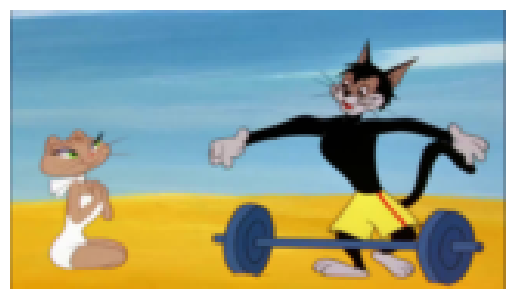

In [7]:
for tensor_image, label in train_data_loader:
    figure, axes = plt.subplots(1,1)

    axes.imshow(torchvision.transforms.ToPILImage()(tensor_image[0]))
    axes.set_axis_off()
    print(label[0])
    break

In [8]:
train_data_loader = fabric.setup_dataloaders(train_data_loader)
val_data_loader = fabric.setup_dataloaders(val_data_loader)
test_data_loader = fabric.setup_dataloaders(test_data_loader)

### define model

In [9]:
model = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V1)

In [31]:
# for param in model.parameters():
#     param.requires_grad = False

In [10]:
model.classifier[1] = nn.Linear(1280,4)

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [12]:
model, optimizer = fabric.setup(model, optimizer)

### train the model

In [24]:
class Haha(L.LightningModule):

    def __init__(self):
        super().__init__()

        self.model = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(1280,4)
    
    def forward(self, images):
        return self.model(images)
    
    def training_step(self, batch, batch_idx):
        images, labels = batch
        prediction = self.model(images)
        loss = nn.functional.cross_entropy(prediction, labels)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        prediction = self.model(images)
        loss = nn.functional.cross_entropy(prediction, labels)
        self.log('val_loss', loss)
    
    def configure_optimizers(self):
        return torch.optim.Adam(model.parameters())

In [25]:
light_t = Haha()
trainer = L.Trainer(max_epochs=5)
trainer.fit(light_t, train_data_loader, val_data_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | MobileNetV2 | 3.5 M 
--------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.019    Total estimated model params size (MB)


Epoch 4: 100%|██████████| 103/103 [01:04<00:00,  1.59it/s, v_num=4]        

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 103/103 [01:04<00:00,  1.58it/s, v_num=4]


In [28]:
trainer.validate(light_t,test_data_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ramin/miniconda3/envs/pytorch_with_notebook/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation DataLoader 0: 100%|██████████| 35/35 [00:09<00:00,  3.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             13.18801212310791
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 13.18801212310791}]